In [1]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from dataset import TinyShakes

from cosmosis.model import GPT
from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
# load dataset
ds_param = {'transforms': {'X1': [AsTensor()], # target
                           'X2': [AsTensor()]},
            'block_size': 10}

ts = TinyShakes(**ds_param)

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  338015
data.nbytes:  676050
CDataset created...


In [3]:
# examine dataset
data = ts[1000]

print(data)
print(data['X1'].shape)
print(type(data['X1']))
print(data['X1'].dtype)

{'X1': tensor([ 198, 1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407]), 'X2': tensor([1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407,  510])}
torch.Size([10])
<class 'torch.Tensor'>
torch.int64


In [4]:
# load model
model_param = {'device': 'cpu',
               'd_model': 8, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 2, 
               'num_layers': 2,
               'linear_head': True,
               'probs': False, # softmax
               'tokens': False, # multinomial
               'transpose': False, 
               'embed_param': {'X1': (50304, 8, None, True),
                               'X2': (50304, 8, None, True)}} 

gpt = GPT(model_param)

CModel loaded...


In [5]:
# load single data example into model and examine output
out = gpt(data)
print(out)
print(out.shape)
print(out.dtype)

tensor([[-1.5189, -0.6265, -0.3118,  ..., -0.0000, -1.0168, -0.6245],
        [-1.5231,  0.3002,  0.4793,  ..., -0.6866, -0.0000, -0.0000],
        [-1.9158, -0.1835,  0.2067,  ..., -0.0000, -0.9768, -0.8793],
        ...,
        [-1.5180,  0.5218,  0.3593,  ..., -0.3322, -0.2801, -0.7053],
        [-0.9496, -0.1074, -0.2530,  ..., -1.1539, -0.0000, -0.8892],
        [-1.0630, -0.1041, -0.0000,  ..., -1.2577, -0.4483, -0.0000]],
       grad_fn=<MulBackward0>)
torch.Size([10, 50304])
torch.float32


In [6]:
# load generated logits and target tokens into loss function
cel_func = CrossEntropyLoss()
prompt_tokens = data['X2']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['X1']
target_tokens.unsqueeze(0)
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_tokens = out
generated_tokens.unsqueeze(0)
print('generated_tokens: ', generated_tokens.unsqueeze(0), generated_tokens.shape, generated_tokens.dtype)

loss = cel_func(generated_tokens, target_tokens)
print('loss: ', loss)

prompt_tokens:  tensor([1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407,  510]) torch.Size([10]) torch.int64
target_tokens:  tensor([ 198, 1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407]) torch.Size([10]) torch.int64
generated_tokens:  tensor([[[-1.5189, -0.6265, -0.3118,  ..., -0.0000, -1.0168, -0.6245],
         [-1.5231,  0.3002,  0.4793,  ..., -0.6866, -0.0000, -0.0000],
         [-1.9158, -0.1835,  0.2067,  ..., -0.0000, -0.9768, -0.8793],
         ...,
         [-1.5180,  0.5218,  0.3593,  ..., -0.3322, -0.2801, -0.7053],
         [-0.9496, -0.1074, -0.2530,  ..., -1.1539, -0.0000, -0.8892],
         [-1.0630, -0.1041, -0.0000,  ..., -1.2577, -0.4483, -0.0000]]],
       grad_fn=<UnsqueezeBackward0>) torch.Size([10, 50304]) torch.float32
loss:  tensor(10.6114, grad_fn=<NllLossBackward0>)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  1000
data.nbytes:  676050
CDataset created...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:09.459025
epoch: 0, lr: 0.01
train loss: 0.3185169868085576, val loss: 0.24910439716445076
last targets: 
PAULINA:
Pray you then,
Conduct me to the queen.


last predictions: 
,

; the,., the: have have the.:? to and
,
:
 the and I the.


 I.:
: the, you,
 and to to to
 is.



...........................
learning time: 0:00:25.915010
epoch: 2, lr: 0.01
train loss: 0.16534855893288536, val loss: 0.15757532086637285
last targets: 
 remember what I must be now!
Swell'st thou, proud
last predictions: 
IPOLAndO- I we as thee
As ' my his, theseThe than is shall!
 come that I this at what's have they,
 come not was what I must be'd!
 meHow'st thou,That

...........................
learning time: 0:00:42.182358
epoch: 4, lr: 0.01
train

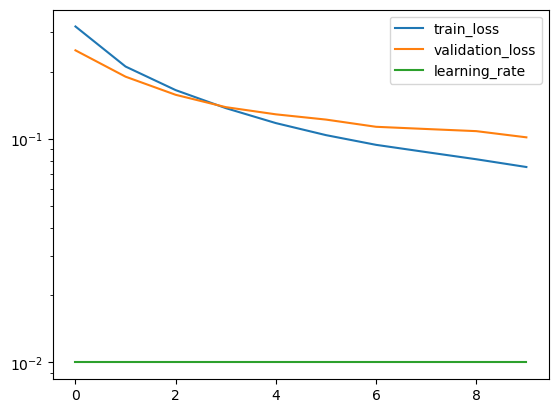

In [2]:
# put all together in a learner
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 50,
                            'n': 1000}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=24, epochs=10, gpu=True, squeeze_y_pred=True, 
              save_model='gpt_test_model', target='X1')

In [2]:
# inference
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 50,
                            'n': 10}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=None,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=100, epochs=2, gpu=True, squeeze_y_pred=True, 
              load_model='gpt_test_model.pth', target='X1')


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  10
data.nbytes:  676050
CDataset created...
CModel loaded...
model loaded from state_dict...
running model on gpu...

...........................
learning time: 0:00:00.931788
last predictions: 
 such whatWh song great high both ceremoniesNorCanLfulness finestling rich speedOL swearIC due bears at citizens self then rebellion blackEN prince CamMay tookwithPS one wickedSeeNor honourMay A courtciusELLPed G rememberNor remember stubborn
inference 2024-12-11 10:48:20.256991 complete and saved to csv...


In [3]:
learn.metrics.predictions

["ixt whatOUWouldaring child both:' abuse fastLxy great fard dumpOLesred hose at fatheray thensent King lie end houses ne hopesendsCan heaven inSeeNor honour ne ATHcius holy Henryost remember part subjectENT",
 ' such whatWh song great high both ceremoniesNorCanLfulness finestling rich speedOL swearIC due bears at citizens self then rebellion blackEN prince CamMay tookwithPS one wickedSeeNor honourMay A courtciusELLPed G rememberNor remember stubborn']